## Titles

In [2]:
import math
import itertools

import numpy as np
import pandas as pd
import seaborn as sns

from scipy import linalg
from scipy import sparse
from scipy.spatial.distance import cosine
from matplotlib import pyplot as plt
from sklearn.metrics import pairwise_distances
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

import data_helpers
import data_titles_helpers
from data_helpers import *
from data_titles_helpers import *
import imp
imp.reload(data_helpers)
imp.reload(data_titles_helpers)

<module 'data_titles_helpers' from '/Users/kyrylo/Projects/personal/thesis/data_titles_helpers.py'>

In [57]:
df_se_subtracks = pd.read_csv(PREPROCESSED_SE_TRACKS_PATH)
df_se_skills = pd.read_csv(PREPROCESSED_SE_SKILLS_PATH)
df_se_subtracks = pd.read_csv(PREPROCESSED_SE_TRACKS_PATH)

se_skill_names = list(df_se_skills[SKILL_TAG_LABEL])
skill_names = list_mask(df_se_subtracks.columns.to_list(), se_skill_names)
print('Total skills count:', len(skill_names))

track_names = list_mask(skill_names, list(df_se_skills[df_se_skills[IS_TRACK_NAME_LABEL] == True][SKILL_TAG_LABEL]))
skill_names = list_filter(skill_names, track_names)


df_titles = pd.DataFrame({
    "title": df_se_subtracks[TITLE_LABEL].unique()
})

df_titles.title = df_titles.title.astype(str)

print('Titles:', df_titles.shape)
df_titles

Total skills count: 136
Titles: (10953, 1)


title
0                                              Developer
1                                   Full Stack Developer
2                                Developer, Scrum Master
3                                       Junior developer
4                                      Software Engineer
...                                                  ...
10948              Junior developer, industrial projects
10949                    Senior/Lead Mobile SW developer
10950  Senior/Lead SW developer (Backend/Full Stack/AWS)
10951  Experienced Software Developer (Backend/Fronte...
10952                    Fullstack developer (part-time)

[10953 rows x 1 columns]

<AxesSubplot:>

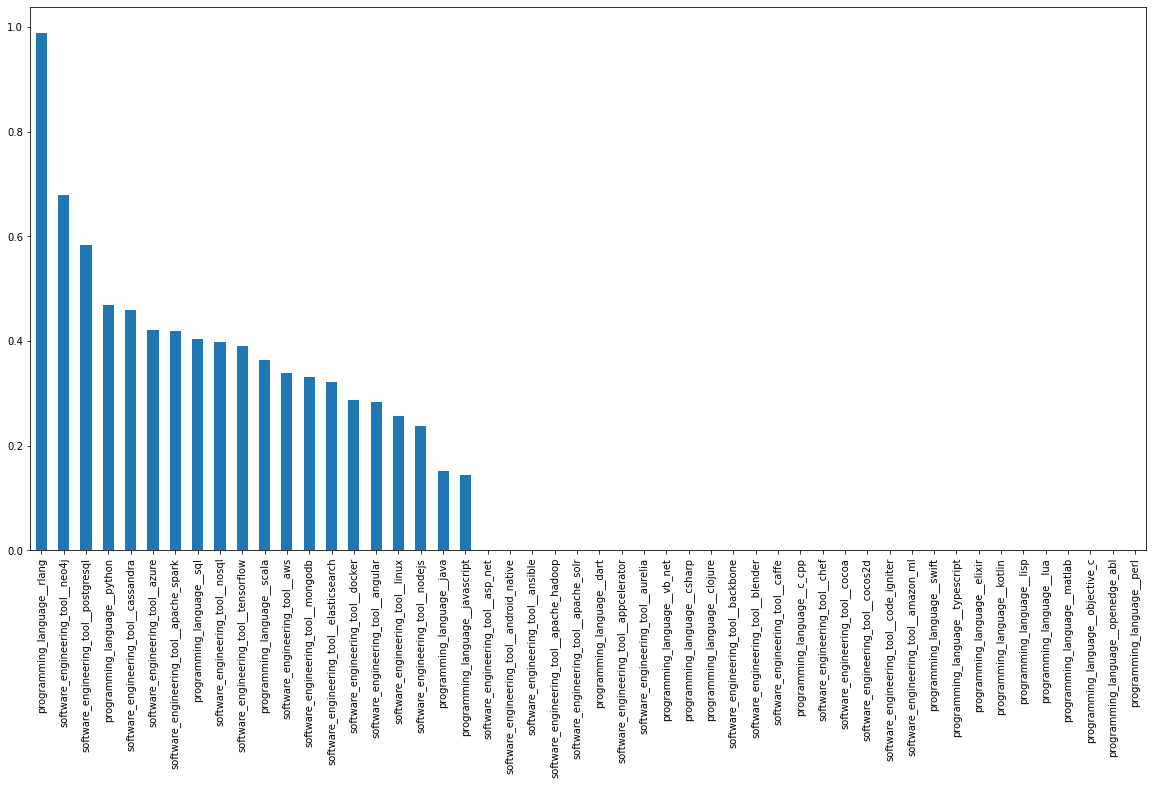

In [265]:
df_se_subtracks.loc[df_se_subtracks['TITLE'].str.contains('data scientist', regex=True)][skill_names].sum().sort_values(ascending=False).nlargest(50).plot(kind='bar', figsize=(20,10))

# Titles normalization

In [6]:
print(df_titles.title.unique().shape)
df_titles.title.value_counts()

(10953,)


Software developer                  1617
Software Engineer                   1571
Software engineer                   1513
Developer                           1125
Software Developer                   995
                                    ... 
Trainee software development           1
Software Development Engineer II       1
Student/Intern                         1
Front-end Developer Intern             1
Business system owner                  1
Name: title, Length: 10953, dtype: int64

In [7]:
cv = CountVectorizer()
cv_sparse_matrix = cv.fit_transform(df_titles.title)

cv_df = sparce_matrix_to_df(cv_sparse_matrix, columns = cv.get_feature_names())
print(cv_df.shape[1])

sorted_words_counts = cv_df.sum().sort_values(ascending=False)
sorted_words_names = list(sorted_words_counts.index)

# sorted_words_names
for index in np.arange(cv_df.shape[1]):
    print(sorted_words_names[index] + ': ' + str(sorted_words_counts[index]))
    if (index > 10):
        break

3241
developer: 18757
software: 12399
engineer: 10211
senior: 5609
end: 2265
lead: 2186
stack: 2057
full: 2052
front: 1948
junior: 1582
web: 1488
frontend: 1401


### StopWords

In [8]:
clean_stop_words(['and', 'a' ,'the'])

['a']

### Rewrite_of

In [9]:
rewrite_of('Senior Manager of Application Development')

'Senior Application Development Manager'

### Labels collection

In [293]:
from data_titles_helpers import *
import imp
imp.reload(data_titles_helpers)

def test_labels_collection(titles, pattern):
    for title in titles:
        print(collect_labels(title, pattern))

#### Seniority 

In [11]:
test_labels_collection(['This senior should junior remain middle senior'], SENIORITY_PATTERNS_MAP)

(['junior', 'middle', 'senior'], 'This should remain ')


#### Roles

In [12]:
test_labels_collection(['engineer This developer should developer remain developer engineer'], ROLE_PATTERNS_MAP)

(['developer', 'engineer'], ' This should remain ')


#### Skills

In [24]:
test_labels_collection(['javascript'], SKILL_PATTERNS_MAP)

(['javascript'], ' ')


#### Fields

In [14]:
test_labels_collection(['senior back-end & full stack developers', 'front - end & qa engineer'], FIELDS_PATTENS_MAP)

(['back-end', 'full-stack'], 'senior & developers')
(['front-end'], ' & qa engineer')


### Apply patterns

In [15]:
apply_patterns('back-end dev', FOLKSONOMY_PATTERS)

'back-end developer '

### Singularize

In [96]:
print(singularize_words(['seniors', 'developers', '!', 'css']))

['senior', 'developer', '!', 'css']


In [297]:
from data_titles_helpers import *
import imp
imp.reload(data_titles_helpers)

normalise_title('Senior Cloud c++ and DevOps with experience of Ful Stack Development | C# | ASP.NET | Python | Dart | React Js', log_labels=True)
normalise_title('mid-level Ruby web developr', log_labels=True)
normalise_title('AI/VR/AR engineer (junior)', log_labels=True)
normalise_title('teamleiter RPA (C++) in Berlin', log_labels=True)
normalise_title('Senior QA Automation / QA Architect', log_labels=True) 
normalise_title('Junior dot net automated testing expert', log_labels=True) 

normalise_title('Ohjelmistokehittäjä, kesätyö (React, node.js)', log_labels=True) 


{'seniority': ['senior'], 'skills': ['c++', 'javascript', 'asp.net', 'python', 'react.js', 'dart', 'c#', '.net'], 'roles': [], 'fields': ['devops', 'cloud', 'development']}
{'seniority': ['middle'], 'skills': ['ruby'], 'roles': ['developer'], 'fields': ['web']}
{'seniority': ['junior'], 'skills': [], 'roles': ['developer'], 'fields': ['ai', 'ar', 'vr']}
{'seniority': ['lead'], 'skills': ['c++'], 'roles': [], 'fields': ['robotic process automation']}
{'seniority': ['senior', 'architector'], 'skills': [], 'roles': [], 'fields': ['quality assurance', 'automation']}
{'seniority': ['junior'], 'skills': ['.net'], 'roles': ['tester'], 'fields': ['automation']}
{'seniority': [], 'skills': ['javascript', 'react.js', 'node.js'], 'roles': ['developer'], 'fields': []}


'kesätyö'

In [18]:
additional_stop_words = list(cv_df.sum()[cv_df.sum() <= 2].index)

In [290]:
from data_titles_helpers import *
import imp
imp.reload(data_titles_helpers)


df = pd.DataFrame({
#     "before": df_titles.title[df_titles.title.str.contains('riak', regex=False)]
    "before": df_titles.title,
})

# df['after'] = df.before.copy().apply(lambda title: normalise_title(title, additional_stop_words) )
df['after'] = df.before.copy().apply(lambda title: normalise_title(title))

df.sort_values(by=['after'], inplace=True)

print('Before titles count: ', len(df.before.unique()))
print('After titles count: ', len(df.after.unique()), '\n')

# a = list(df_titles.title.apply(normalise_title).sort_values().unique())

df.drop_duplicates(subset=['after'], keep='first', inplace=True)

# print(df['after'].value_counts())

for ix, row in df.iterrows():
    print(row[1].ljust(80, " "), '🔥' + row[0])
#     print('Before: "' + row[0] + '"')
#     print('After: "' + row[1] + '" \n')


# cv = CountVectorizer()
# cv_sparse_matrix = cv.fit_transform(df.after)

# cv_df = sparce_matrix_to_df(cv_sparse_matrix, columns = cv.get_feature_names())
# print(cv_df.shape[1])

# sorted_words_counts = cv_df.sum().sort_values(ascending=False)
# sorted_words_names = list(sorted_words_counts.index)

# # sorted_words_names
# for index in np.arange(cv_df.shape[1]):
#     print(sorted_words_names[index] + ': ' + str(sorted_words_counts[index]))


Before titles count:  10953
After titles count:  2471 

                                                                                 🔥Developer
1c                                                                               🔥Programmer 1C
1ma                                                                              🔥1MA
2                                                                                🔥(Senior) PHP/Symfony2 Developer (m/f)
2nd                                                                              🔥2nd year Engineering Student at JAMK University of Applied Sciences 
3d                                                                               🔥Freelance C# / Unity 3D developer
3d artist                                                                        🔥Unity developer / 3D artist
3d generalist                                                                    🔥3d Generalist / Programmer
3rd                                                             